In [ ]:
!pip install -q mediapipe==0.10.0

In [ ]:
#Obect detection module
!wget -q -O efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite
#@title Start downloading here.
!wget -O deeplabv3.tflite -q https://storage.googleapis.com/mediapipe-models/image_segmenter/deeplab_v3/float32/1/deeplab_v3.tflite

In [ ]:
import os

def zmien_spacje_na_podkreslenia(katalog):
    for nazwa_pliku in os.listdir(katalog):
        if ' ' in nazwa_pliku:
            nowa_nazwa = nazwa_pliku.replace(' ', '_')
            stara_sciezka = os.path.join(katalog, nazwa_pliku)
            nowa_sciezka = os.path.join(katalog, nowa_nazwa)
            os.rename(stara_sciezka, nowa_sciezka)

# Użyj funkcji na konkretnym katalogu
zmien_spacje_na_podkreslenia('img')

In [ ]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [2]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob

def show_list_images(lista_obrazow, liczba_kolumn=2, figsize=(20, 60)):
    """
    Showing list of images
    """

    # Obliczenie liczby wierszy na podstawie liczby obrazów i kolumn
    liczba_wierszy = -(-len(lista_obrazow) // liczba_kolumn)  # Zaokrąglenie w górę

    # Utworzenie figury i osi
    fig = plt.figure(figsize=figsize)
    fig, osie = plt.subplots(nrows=liczba_wierszy, ncols=liczba_kolumn)

    # Wyświetlanie obrazów
    for i, obraz in enumerate(lista_obrazow):
        os_x = i // liczba_kolumn
        os_y = i % liczba_kolumn
        osie[os_x, os_y].imshow(obraz)
        #osie[os_x, os_y].set_title(f'Obraz {i+1}')
        osie[os_x, os_y].axis('off')  # Wyłączenie osi

    plt.tight_layout()
    plt.show()

def cutting_full_body(
    image,
    detection_result, padding = 20
) -> np.ndarray:
  """Image cut with using bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be cut.
  Returns:
    Part of image.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    # Wycięcie fragmentu obrazu
    image_cut = image[bbox.origin_y - padding : bbox.origin_y+bbox.height - padding,
                      bbox.origin_x - padding : bbox.origin_x+bbox.width + padding]
  return image_cut


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """

  MARGIN = 10  # pixels
  ROW_SIZE = 10  # pixels
  FONT_SIZE = 1
  FONT_THICKNESS = 1
  TEXT_COLOR = (255, 0, 0)  # red
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    # Wycięcie fragmentu obrazu
    image_cut = image[bbox.origin_y:bbox.origin_y+bbox.height, bbox.origin_x:bbox.origin_x+bbox.width]
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)
    
    # Draw label and score
    
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x, MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN, FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)
   
  return image

def popraw_kontrast(obraz):

    kanaly = cv2.split(obraz)
    kanaly_wyrownane = [cv2.equalizeHist(kanal) for kanal in kanaly]
    obraz_wyrownany = cv2.merge(kanaly_wyrownane)

    return obraz_wyrownany


<Figure size 4000x3000 with 0 Axes>

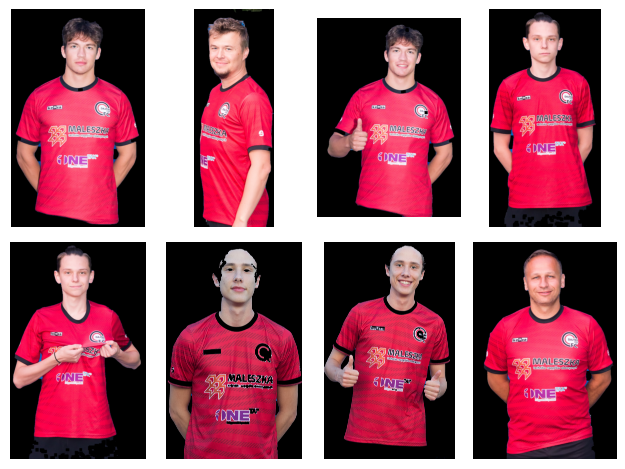

In [4]:
#Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.4, max_results=1,running_mode=vision.RunningMode.IMAGE )
detector = vision.ObjectDetector.create_from_options(options)



img_list = []
for id, image_path in enumerate(glob('img/*.jpg')):
   

    image = mp.Image.create_from_file(image_path)
    # Detect objects in the input image.
    detection_result = detector.detect(image)

    # Process the image
    image_copy = np.copy(image.numpy_view())
    image_cut = cutting_full_body(image_copy, detection_result)
    #image_cut = popraw_kontrast(image_cut)
    try:
        # HSV
        
        hsv = cv2.cvtColor(image_cut, cv2.COLOR_BGR2HSV)
        h = hsv[:,:,0]
        _, mask = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        #lower_blue = np.array([20, 0, 0])
        #upper_blue = np.array([255, 255, 255])

        #mask = cv2.inRange(hsv, lower_blue, upper_blue)
        #mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
        
        kernel = np.ones((3,3),np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=7)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_largest_contour = np.zeros_like(mask)
        # Max countour
        """
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask_largest_contour, [largest_contour], -1, (255), thickness=cv2.FILLED)
        # Zastosuj maskę do obrazu
        res = cv2.bitwise_and(image_cut,image_cut, mask= mask_largest_contour)
        """
        res = cv2.bitwise_and(image_cut,image_cut, mask= mask)
        img_list.append(res)
    except:
        print(image_path)
    if id>6: break

show_list_images(img_list, 4, (40, 30))


In [7]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

In [8]:
def face_size_landmarks():
    landmarks_list = [
        detection_result.face_landmarks[0][134].x, detection_result.face_landmarks[0][10].y,
        detection_result.face_landmarks[0][454].x, detection_result.face_landmarks[0][134].y]
    return landmarks_list

def draw_rectangle_face_detector(image):
    # Załóżmy, że 'image' to Twój obraz
    height, width = image.shape[:2]

    # Znormalizowane współrzędne lewo 134, góra 10 , prawo 454, dół 152
    x, y, x2, y2 = face_size_landmarks(detection_result)

    # Przeskaluj współrzędne do rozmiaru obrazu
    start_point = (int(x * width), int(y * height))
    end_point = (int(x2 * width), int(y2 * height))

    # Kolor prostokąta (BGR)
    color = (255, 0, 0)

    # Grubość linii prostokąta
    thickness = 2

    # Rysowanie prostokąta na obrazie
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    return image

In [10]:
#wykrywanie szczegółów twarzy
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
img_list3 = []
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)


for image in img_list:
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB,data=image.astype(np.uint8))
    print(detector)
    detection_result = detector.detect(mp_image)
    annotated_image_cv = draw_rectangle_face_detector(image)
    #face_img= np.copy(mp_image.numpy_view())
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
    #annotated_image = mp.Image(image_format=mp.ImageFormat.SRGB,data=annotated_image_cv.astype(np.uint8))
    
    img_list3.append(annotated_image)
show_list_images(img_list3, 4, (40, 30))    

W20231022 21:38:16.320398  3363 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


TypeError: face_size_landmarks() takes 0 positional arguments but 1 was given

In [13]:
face_size_landmarks()

[0.5109323859214783,
 0.12204320728778839,
 0.642035961151123,
 0.20565703511238098]

In [10]:
face_landmarks_list = detection_result.face_landmarks
face_landmarks_list

[[NormalizedLandmark(x=0.5261018872261047, y=0.24010613560676575, z=-0.026395896449685097, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5285865068435669, y=0.2190927416086197, z=-0.05677922070026398, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5268243551254272, y=0.2251393049955368, z=-0.02763533405959606, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5209583640098572, y=0.19693367183208466, z=-0.045710489153862, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5292456150054932, y=0.21261511743068695, z=-0.06121931970119476, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5296918153762817, y=0.2037804126739502, z=-0.05801261216402054, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5310114026069641, y=0.18214532732963562, z=-0.03276675567030907, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.456765741109848, y=0.17535901069641113, z=0.006988578010350466, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.531817257404

In [ ]:
import numpy as np

def calculate_bounding_box(face_landmarks):
    x_coordinates = [landmark.x for landmark in face_landmarks.landmark]
    y_coordinates = [landmark.y for landmark in face_landmarks.landmark]
    
    return (min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates))

for image in img_list:
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB,data=image.astype(np.uint8))
    detection_result = detector.detect(mp_image)
    face_img= np.copy(mp_image.numpy_view())
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
    
    # Calculate bounding box for each face
    for face_landmarks in detection_result.face_landmarks:
        bounding_box = calculate_bounding_box(face_landmarks)
        print(f"Bounding box for face: {bounding_box}")
    
    img_list3.append(annotated_image)
show_list_images(img_list3, 4, (40, 30))

In [ ]:
#Wykrywanie twarzy
import mediapipe as mp

BaseOptionsFace = mp.tasks.BaseOptions
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode
img_list2=[]
# Create a face detector instance with the image mode:
optionsFace = FaceDetectorOptions(
    base_options=BaseOptionsFace(model_asset_path='blaze_face_short_range.tflite'),
    running_mode=VisionRunningMode.IMAGE)
with FaceDetector.create_from_options(optionsFace) as detector:
    for image in img_list:
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB,data=image.astype(np.uint8))
        face_detector_result = detector.detect(mp_image)
        face_img= np.copy(mp_image.numpy_view())
        face_cut = cutting_full_body(face_img, face_detector_result)
        img_list2.append(face_cut)
show_list_images(img_list2, 4, (40, 30))

In [ ]:
import mediapipe as mp

# Initialize MediaPipe Face Mesh.
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# Assume image is your input image
results = face_mesh.process(img_list2[0])

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Get the coordinates of landmarks for nose tip and chin.
        nose_tip = [i.x, i.y, i.z] for i in face_landmarks.landmark[4]
        chin = [i.x, i.y, i.z] for i in face_landmarks.landmark[152]

        # Calculate the distance between nose tip and chin.
        face_size = np.linalg.norm(np.array(nose_tip) - np.array(chin))

In [ ]:
# Konwertuj obraz na przestrzeń kolorów HSV
hsv = cv2.cvtColor(image_cut, cv2.COLOR_BGR2HSV)

# Zdefiniuj zakres koloru niebieskiego
lower_blue = np.array([30,0,0])
upper_blue = np.array([255,255,255])

# Utwórz maskę dla koloru niebieskiego
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Znajdź kontury w masce
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_largest_contour = np.zeros_like(mask)
# Sprawdź, czy znaleziono jakiekolwiek kontury
if contours:
    # Znajdź największy kontur na podstawie powierzchni
    largest_contour = max(contours, key=cv2.contourArea)
    # Utwórz nową maskę o tym samym rozmiarze co oryginalna
    
    # Narysuj największy kontur na nowej masce
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, (255), thickness=cv2.FILLED)

# Zastosuj maskę do obrazu
res = cv2.bitwise_and(image_cut,image_cut, mask= mask_largest_contour)
plt.imshow(res)
plt.show()

In [ ]:
# Konwertuj obraz na przestrzeń kolorów HSV
hsv = cv2.cvtColor(image_cut, cv2.COLOR_BGR2HSV)

# Zdefiniuj zakres koloru niebieskiego
lower_blue = np.array([30,0,0])
upper_blue = np.array([255,255,255])

# Utwórz maskę dla koloru niebieskiego
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Znajdź kontury w masce
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#Operacja zamknięcia
kernel_size = 3  # Możesz dostosować tę wartość do swoich potrzeb
kernel = np.ones((kernel_size, kernel_size), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)
#wygłaź krawędzie w masce
#mask_largest_contour = cv2.blur(mask_largest_contour, (3, 3))
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (42, 42))
#opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)
#mask = cv2.GaussianBlur(mask, (3, 3), 8, 8)

# Zastosuj maskę do obrazu
res = cv2.bitwise_and(image_cut,image_cut, mask= mask)
plt.imshow(mask)
plt.show()

In [ ]:
import skimage.exposure
# Podzielenie obrazu na kanały
b_channel, g_channel, r_channel = cv2.split(image_cut)

# Dodanie kanału alfa do obrazu
#erozja w celu zmniejszenia maski o kilka px
kernel_size = 3  # Możesz dostosować tę wartość do swoich potrzeb
kernel = np.ones((kernel_size, kernel_size), np.uint8)
# Wykonaj erozję
eroded_mask = cv2.erode(mask, kernel, iterations=1)

# Rozmycie Gaussowskie
blur = cv2.GaussianBlur(eroded_mask, (0,0), sigmaX=1, sigmaY=1, borderType=cv2.BORDER_REPLICATE)

# Przeskalowanie intensywności
result = skimage.exposure.rescale_intensity(blur, in_range=(128,255), out_range=(0,255))

alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * blur
img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
img_RGBA = cv2.cvtColor(img_BGRA, cv2.COLOR_BGRA2RGBA)
cv2.imwrite('output.png', img_RGBA)

In [ ]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt
from PIL import Image

# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5, max_results=1,running_mode=vision.RunningMode.IMAGE )
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('img/JSK59245.jpg')

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

#GRABCUT
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

detection = detection_result.detections[0]
# Draw bounding_box
bbox = detection.bounding_box
image_copy = np.copy(image.numpy_view())
mask = np.zeros(image_copy.shape[:2], np.uint8)
# Zdefiniuj prostokąt wokół osoby
rect = (bbox.origin_x,bbox.origin_y,bbox.width,bbox.height)

# Wywołaj funkcję grabCut
cv2.grabCut(image_copy, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Zastosuj maskę
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = image_copy*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.show()

In [ ]:
type(image_cut)

In [ ]:
face_detector_result

Preview the downloaded image
With the test image downloaded, go ahead and display it.

In [ ]:
import urllib

IMAGE_FILENAMES = ['segmentation_input_rotation0.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

In [ ]:
import cv2
#from google.colab.patches import cv2_imshow
import math
from matplotlib import pyplot as plt

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))

  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.imshow(img_rgb)
  plt.show()


Running inference and visualizing the results
To run inference using the image segmentation MediaPipe Task, you will need to initialize the ImageSegmenter using the model. This example will separate the background and foreground of the image and apply separate colors for them to highlight where each distinctive area exists. Image segmentation here will use a category mask, which applies a category to each found item based on confidence

In [ ]:
import numpy as np
import mediapipe as mp
import math

from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt

IMAGE_FILENAMES = ['img/JSK58549.jpg']

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  plt.imshow(img)
  plt.show()

BG_COLOR = (0, 0, 0) # gray
MASK_COLOR = (255, 255, 255) # white


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
    output_image = np.where(condition, fg_image, bg_image)

    print(f'Segmentation mask of {name}:')
    plt.imshow(image_data)
    plt.imshow(output_image)
    plt.show()

In [ ]:
import cv2

# Wczytaj obraz
image = cv2.imread('img\JSK58507.jpg')

# Utwórz detektor HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Wykonaj detekcję ciała ludzkiego na obrazie
boxes, weights = hog.detectMultiScale(image, winStride=(4, 4), padding=(8, 8), scale=1.05)

# Narysuj prostokątne ramki wokół wykrytych osób
for (x, y, w, h) in boxes:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
plt.imshow(image)
#plt.imshow(output_image)
plt.show()

In [ ]:
import cv2
print(cv2.getBuildInformation())